In [ ]:
%pip install torch
%pip install torchvision
%pip install torchsummary
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install pillow

In [104]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from PIL import Image

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [106]:
device

'mps'

In [107]:
train_df = pd.read_csv('./data/train.csv')
val_df = pd.read_csv('./data/val.csv')

In [108]:
train_df.head()

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0


In [109]:
train_df['category'].unique()

array([0, 1, 2])

In [110]:
train_df.shape, val_df.shape

((1034, 2), (133, 2))

In [111]:
train_df['category'].value_counts(), val_df['category'].value_counts()

(category
 2    348
 1    345
 0    341
 Name: count, dtype: int64,
 category
 2    45
 0    44
 1    44
 Name: count, dtype: int64)

In [112]:
transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

In [113]:
class CustomImageDataSet(Dataset):
    def __init__(self, root_dir, dataframe, transform=None):
        super(Dataset, self).__init__()
        self.root_dir = root_dir
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.Tensor(self.dataframe['category']).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.dataframe.iloc[index, 0])
        image = Image.open(image_path)
        label = self.labels[index]
        if self.transform:
            image = self.transform(image) / 255.0
        image = image.to(device)
        return image, label


In [114]:
train_dataset = CustomImageDataSet('./data', train_df, transform=transform)
val_dataset = CustomImageDataSet('./data', val_df, transform=transform)

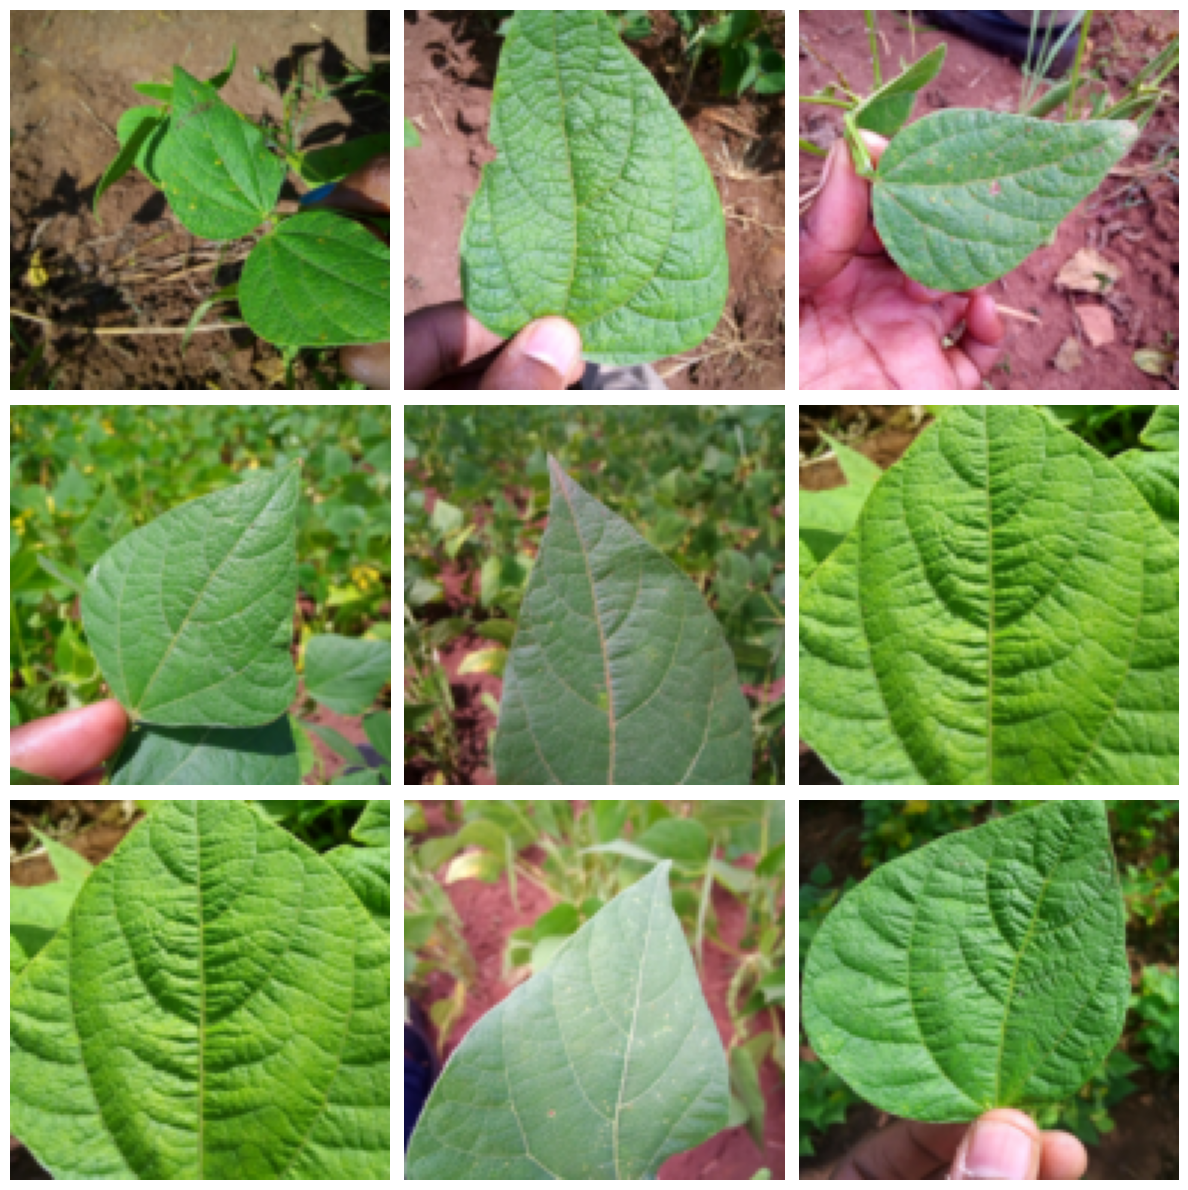

In [115]:
n_rows = 3
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12))

for row in range(n_rows):
    for col in range(n_cols):
        img = train_dataset[np.random.randint(train_dataset.__len__())][0].cpu()
        axs[row, col].imshow(
            (img * 255.0).squeeze().permute(1, 2, 0))  # permute 是将通道维放到最后，pytorch的（C,H,W）转换为 matplotlib 需要的 （H,W,C）
        axs[row, col].axis('off')

plt.tight_layout()


In [116]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [117]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [118]:
google_net_model = models.googlenet(weights='DEFAULT')

In [119]:
for param in google_net_model.parameters():
    param.requires_grad = True


In [120]:
google_net_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [121]:
num_classes = len(train_df['category'].unique())
num_classes

3

In [122]:
google_net_model.fc = nn.Linear(google_net_model.fc.in_features, num_classes)
google_net_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [123]:
google_net_model = google_net_model.to(device)

In [124]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(google_net_model.parameters(), lr=LR)

In [129]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_acc_train = 0

    google_net_model.train()

    for images, labels in train_loader:
        optimizer.zero_grad()
        train_outputs = google_net_model(images)
        train_loss = loss_fn(train_outputs, labels)
        train_loss.backward()
        optimizer.step()

        total_loss_train += train_loss.item()

        train_acc = labels.eq(train_outputs.argmax(dim=1)).sum().item()
        total_acc_train += train_acc

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_acc_train_plot.append(round(total_acc_train / train_dataset.__len__() * 100, 4))

    print(
        f'Epoch: {epoch + 1}/{EPOCHS} | Train Loss: {total_loss_train_plot[-1]} | Train Acc: {total_acc_train_plot[-1]}')

Epoch: 1/15 | Train Loss: 0.1003 | Train Acc: 85.5899
Epoch: 2/15 | Train Loss: 0.0986 | Train Acc: 86.8472
Epoch: 3/15 | Train Loss: 0.0863 | Train Acc: 87.5242
Epoch: 4/15 | Train Loss: 0.096 | Train Acc: 87.234
Epoch: 5/15 | Train Loss: 0.085 | Train Acc: 88.6847
Epoch: 6/15 | Train Loss: 0.0777 | Train Acc: 88.4913
Epoch: 7/15 | Train Loss: 0.0749 | Train Acc: 90.0387
Epoch: 8/15 | Train Loss: 0.0629 | Train Acc: 91.9729
Epoch: 9/15 | Train Loss: 0.0687 | Train Acc: 91.7795
Epoch: 10/15 | Train Loss: 0.0605 | Train Acc: 91.9729
Epoch: 11/15 | Train Loss: 0.0644 | Train Acc: 91.1992
Epoch: 12/15 | Train Loss: 0.0517 | Train Acc: 93.3269
Epoch: 13/15 | Train Loss: 0.056 | Train Acc: 93.0368
Epoch: 14/15 | Train Loss: 0.0629 | Train Acc: 91.2959
Epoch: 15/15 | Train Loss: 0.0603 | Train Acc: 93.4236


In [130]:
with torch.inference_mode():
    total_loss_test = 0
    total_acc_test = 0

    for images, labels in val_loader:
        outputs = google_net_model(images)

        test_loss = loss_fn(outputs, labels)
        total_loss_test += test_loss.item()

        test_acc = labels.eq(outputs.argmax(dim=1)).sum().item()
        total_acc_test += test_acc


    print(round(total_acc_test / val_dataset.__len__() * 100, 2))


87.97
